<a href="https://colab.research.google.com/github/norim-user/Worldmodel-Report/blob/main/%E6%9C%80%E7%B5%82%E8%AA%B2%E9%A1%8C_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

実験手順1.2種類のエージェントの実装とグリッドワールドの構築

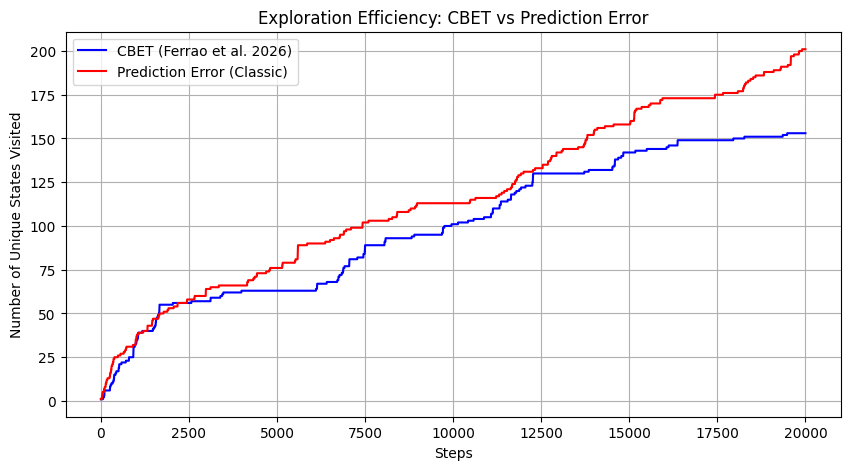

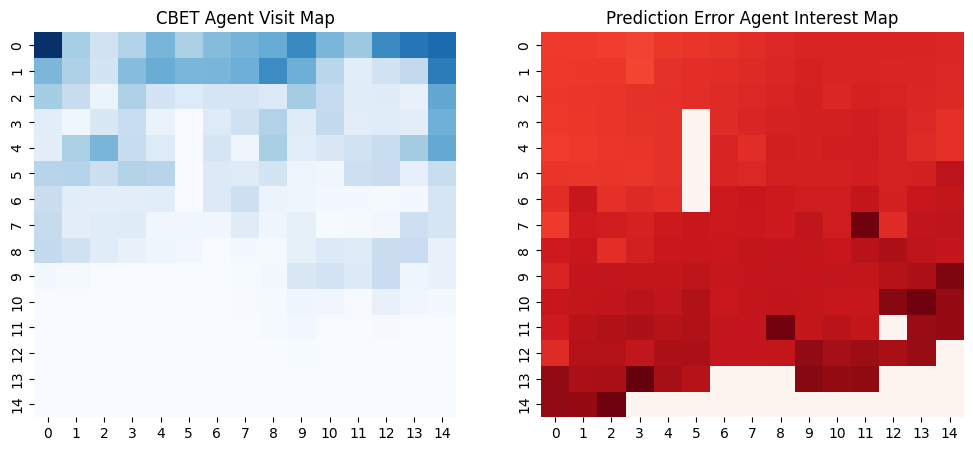

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns


#1.シンプルグリッドワールドの作成

class GridWorld:
    def __init__(self, size=10):
        self.size = size
        self.state = (0, 0)
        # Create a simple map (0: Empty, 1: Wall)
        self.map = np.zeros((size, size))
        self.map[3:7, 5] = 1
        self.reset()

    def reset(self):
        self.state = (0, 0)
        return self.state

    def step(self, action):
        # Actions: 0:Up, 1:Right, 2:Down, 3:Left
        moves = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        dy, dx = moves[action]
        ny, nx = self.state[0] + dy, self.state[1] + dx

        # Check boundaries and walls
        if 0 <= ny < self.size and 0 <= nx < self.size and self.map[ny, nx] == 0:
            next_state = (ny, nx)
            change = 1 # Position changed
        else:
            next_state = self.state
            change = 0 # Bumped into wall (No position change)

        self.state = next_state
        return next_state, change

#2.The World Model
class SimpleWorldModel:
    def __init__(self, size):
        # Model stores: "If I am at (y,x) and do action A, where do I go?"
        # Initialize with specific negative value to indicate "unknown"
        self.model = np.full((size, size, 4, 2), -1.0)

    def predict(self, state, action):
        y, x = state
        pred = self.model[y, x, action]
        if pred[0] == -1: # No memory yet
            return state # Assume I stay here (naive prediction)
        return tuple(pred.astype(int))

    def update(self, state, action, next_state):
        y, x = state
        self.model[y, x, action] = next_state

# 3. The Agent with Intrinsic Motivation(2種類のエージェントの実装)
class CuriousAgent:
    def __init__(self, size, method='cbet'):
        self.world_model = SimpleWorldModel(size)
        self.method = method # 'cbet' or 'prediction_error'
        self.q_table = np.zeros((size, size, 4)) # To learn policy

        # For CBET
        self.state_counts = np.zeros((size, size))
        self.change_counts = np.zeros((size, size))

        # History for plotting
        self.visited_states = set()
        self.exploration_rate = []

    def get_action(self, state, epsilon=0.1):
        if random.random() < epsilon:
            return random.randint(0, 3)
        y, x = state
        return np.argmax(self.q_table[y, x])

    def calculate_intrinsic_reward(self, state, action, next_state, change):
        y, x = next_state

        # Method A: CBETモデル
        if self.method == 'cbet':
            # Eq 1: r = 1 / (n(s) + n(c))
            n_s = self.state_counts[y, x]
            n_c = self.change_counts[y, x]
            # Avoid division by zero, add small epsilon
            reward = 1.0 / (np.sqrt(n_s) + np.sqrt(n_c) + 0.1)

            # Update counts
            self.state_counts[y, x] += 1
            if change > 0:
                self.change_counts[y, x] += 1

        # Method B: Prediction Error(予測誤差モデル)
        elif self.method == 'prediction_error':
            predicted_next = self.world_model.predict(state, action)
            # Distance between predicted and actual
            error = np.sqrt((predicted_next[0] - y)**2 + (predicted_next[1] - x)**2)
            reward = error # The bigger the error, the bigger the reward

            # Update World Model
            self.world_model.update(state, action, next_state)

        return reward

    def train(self, env, steps=2000):
        state = env.reset()
        self.visited_states.add(state)

        for t in range(steps):
            action = self.get_action(state)
            next_state, change = env.step(action)

            # 1. Calculate Intrinsic Reward
            reward = self.calculate_intrinsic_reward(state, action, next_state, change)

            # 2. Q-Learning Update (Simple RL)
            y, x = state
            ny, nx = next_state
            best_next_q = np.max(self.q_table[ny, nx])
            self.q_table[y, x, action] += 0.1 * (reward + 0.9 * best_next_q - self.q_table[y, x, action])

            state = next_state
            self.visited_states.add(state)

            # Record exploration rate
            self.exploration_rate.append(len(self.visited_states))

#4.モデルの実行
env_size = 15
steps = 20000

# Run CBET Agent
env = GridWorld(env_size)
agent_cbet = CuriousAgent(env_size, method='cbet')
agent_cbet.train(env, steps)

# Run Prediction Error Agent
env = GridWorld(env_size)
agent_pred = CuriousAgent(env_size, method='prediction_error')
agent_pred.train(env, steps)

# 5.結果

plt.figure(figsize=(10, 5))
plt.plot(agent_cbet.exploration_rate, label='CBET (Ferrao et al. 2026)', color='blue')
plt.plot(agent_pred.exploration_rate, label='Prediction Error (Classic)', color='red')
plt.xlabel('Steps')
plt.ylabel('Number of Unique States Visited')
plt.title('Exploration Efficiency: CBET vs Prediction Error')
plt.legend()
plt.grid(True)
plt.show()

# Heatmap of visits for CBET
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(agent_cbet.state_counts, cmap="Blues", cbar=False)
plt.title("CBET Agent Visit Map")

# Heatmap of visits for Prediction Error
# Let's show the Q-table max values as a proxy for "interest"
plt.subplot(1, 2, 2)
sns.heatmap(np.max(agent_pred.q_table, axis=2), cmap="Reds", cbar=False)
plt.title("Prediction Error Agent Interest Map")
plt.show()

実験手順2.ノイズトラップのあるグリッドワールドの構築

Running Experiment... This may take a few seconds.
Prediction Error Agent Trap Visits: 0
CBET Agent Trap Visits: 0


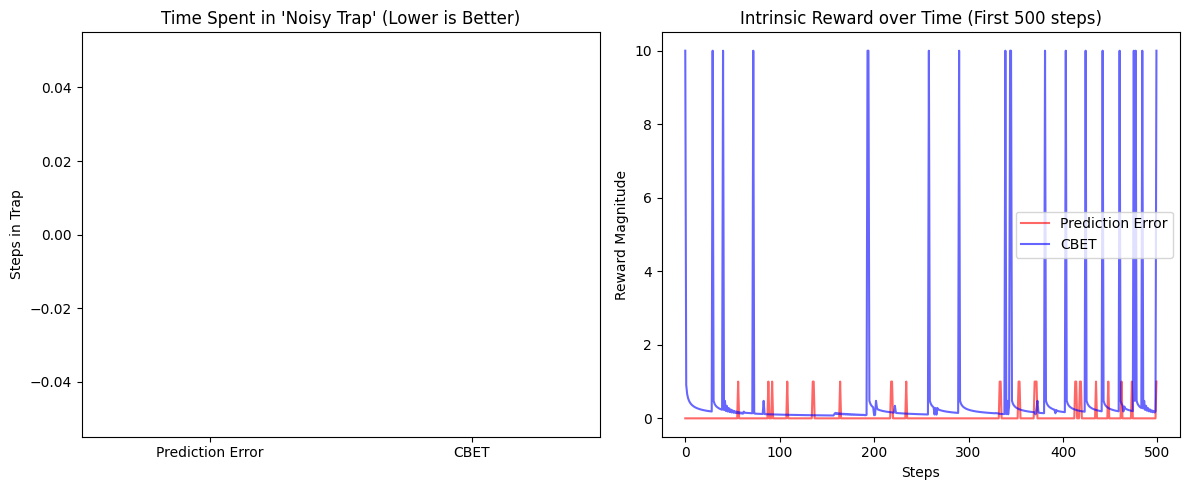

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

#1.ノイズトラップのあるグリッドワールドの構築
class NoisyGridWorld:
    def __init__(self, size=10):
        self.size = size
        self.state = (0, 0)
        self.goal = (size-1, size-1)
        # Trap location (The "Noisy TV")
        self.trap_loc = (size//2, size//2)

    def reset(self):
        self.state = (0, 0)
        return self.get_observation()

    def get_observation(self):
        # Normal state returns its coordinate as observation vector
        obs = np.array([self.state[0], self.state[1]], dtype=float)

        # If in TRAP, add random noise! (The "Noisy TV" effect)
        if self.state == self.trap_loc:
            noise = np.random.uniform(-5, 5, size=2) # Big random noise
            return obs + noise
        return obs

    def step(self, action):
        # Actions: 0:Up, 1:Right, 2:Down, 3:Left
        moves = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        dy, dx = moves[action]
        ny, nx = self.state[0] + dy, self.state[1] + dx

        # Wall handling (Boundaries)
        if 0 <= ny < self.size and 0 <= nx < self.size:
            next_state = (ny, nx)
            change_flag = 1 # Position changed
        else:
            next_state = self.state
            change_flag = 0 # Hit wall

        self.state = next_state
        return self.get_observation(), change_flag, self.state

#2.World Model(Predictor)
class TabularWorldModel:
    def __init__(self, size):
        # Maps (y, x, action) -> Predicted Observation (2D vector)
        self.model = np.zeros((size, size, 4, 2))
        self.visited_count = np.zeros((size, size, 4)) # To learn average

    def predict(self, state_coord, action):
        y, x = state_coord
        if self.visited_count[y, x, action] == 0:
            return np.array([y, x], dtype=float) # Default prediction
        return self.model[y, x, action]

    def update(self, state_coord, action, actual_obs):
        y, x = state_coord
        # Simple moving average to learn the "expected" observation
        n = self.visited_count[y, x, action] + 1
        self.model[y, x, action] += (actual_obs - self.model[y, x, action]) / n
        self.visited_count[y, x, action] = n

#3.Agent
class Agent:
    def __init__(self, size, method):
        self.size = size
        self.method = method # 'prediction_error' or 'cbet'
        self.q_table = np.zeros((size, size, 4))
        self.world_model = TabularWorldModel(size)

        # CBET specific memory
        self.state_counts = np.zeros((size, size))
        self.change_counts = np.zeros((size, size))

        # Logs
        self.history_rewards = []
        self.trap_visits = 0

    def get_action(self, state_coord, epsilon=0.1):
        if np.random.rand() < epsilon:
            return np.random.randint(4)
        y, x = state_coord
        return np.argmax(self.q_table[y, x])

    def train(self, steps=3000):
        env = NoisyGridWorld(self.size)
        obs = env.reset()
        curr_coord = (0, 0)

        for t in range(steps):
            action = self.get_action(curr_coord)
            next_obs, change, next_coord = env.step(action)

            #Intrinsic Reward Calculation
            reward = 0.0

            #報酬は予測に対する誤差
            if self.method == 'prediction_error':
                # Prediction Error = |Prediction - Actual|
                pred_obs = self.world_model.predict(curr_coord, action)
                error = np.linalg.norm(pred_obs - next_obs)
                reward = error

                # Update World Model
                self.world_model.update(curr_coord, action, next_obs)

            #学習の進捗(Update Counts)によって飽きが発生
            elif self.method == 'cbet':
                # CBET = 1 / (sqrt(N_state) + sqrt(N_change))
                y, x = next_coord
                n_s = self.state_counts[y, x]
                n_c = self.change_counts[y, x]
                reward = 1.0 / (np.sqrt(n_s) + np.sqrt(n_c) + 0.1)

                # Update Counts
                self.state_counts[y, x] += 1
                if change: self.change_counts[y, x] += 1

            # Q-Learning Update
            cy, cx = curr_coord
            ny, nx = next_coord
            best_next_q = np.max(self.q_table[ny, nx])
            self.q_table[cy, cx, action] += 0.1 * (reward + 0.9 * best_next_q - self.q_table[cy, cx, action])

            # Logging
            if curr_coord == env.trap_loc:
                self.trap_visits += 1
            self.history_rewards.append(reward)

            obs = next_obs
            curr_coord = next_coord

#4.実行と可視化
print("Running Experiment... This may take a few seconds.")

# 1. Run Prediction Error Agent
agent_noise = Agent(size=15, method='prediction_error')
agent_noise.train(steps=5000)

# 2. Run CBET Agent
agent_cbet = Agent(size=15, method='cbet')
agent_cbet.train(steps=5000)

print(f"Prediction Error Agent Trap Visits: {agent_noise.trap_visits}")
print(f"CBET Agent Trap Visits: {agent_cbet.trap_visits}")

# --- Plotting ---
plt.figure(figsize=(12, 5))

# Plot 1: Visitation Heatmap (Prediction Error)
plt.subplot(1, 2, 1)
# We reconstruct visit counts for visualization from Q-table updates logic or logs
# Here let's just use the trap visit count as the main metric
plt.bar(['Prediction Error', 'CBET'], [agent_noise.trap_visits, agent_cbet.trap_visits], color=['red', 'blue'])
plt.title("Time Spent in 'Noisy Trap' (Lower is Better)")
plt.ylabel("Steps in Trap")

# Plot 2: Intrinsic Reward History
plt.subplot(1, 2, 2)
plt.plot(agent_noise.history_rewards[:500], label='Prediction Error', color='red', alpha=0.6)
plt.plot(agent_cbet.history_rewards[:500], label='CBET', color='blue', alpha=0.6)
plt.title("Intrinsic Reward over Time (First 500 steps)")
plt.xlabel("Steps")
plt.ylabel("Reward Magnitude")
plt.legend()

plt.tight_layout()
plt.show()

実験手順3.2種類のエージェントがノイズトラップを踏むように探索のステップを複数回実行

🧪 実験開始: 50000ステップの探索を行います...
🔴 Baseline (Prediction Error) Agent 実行中...
🔵 Proposed (CBET) Agent 実行中...
✅ 実験完了。グラフを生成します。


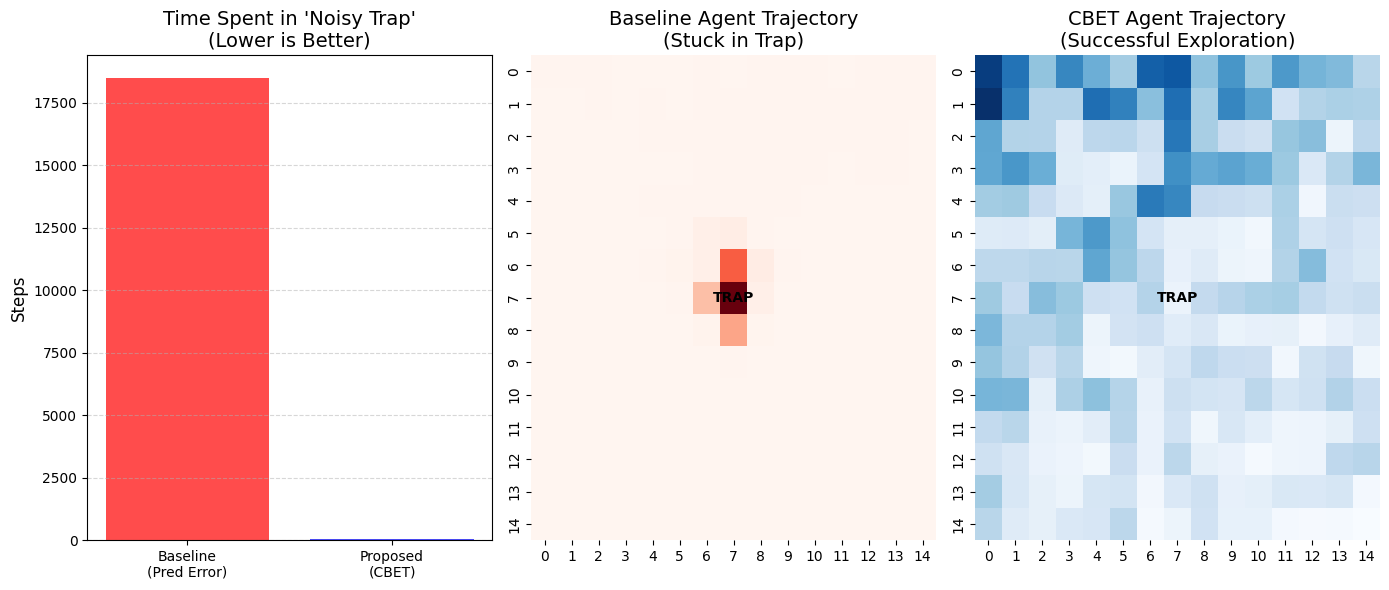

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

#1.ノイズのある世界
class NoisyGridWorld:
    def __init__(self, size=15):
        self.size = size
        self.state = (0, 0)
        #マップの中央にノイズトラップを設置
        self.trap_loc = (size//2, size//2)

    def reset(self):
        self.state = (0, 0)
        return self.get_observation()

    def get_observation(self):
        #通常は座標が見える
        obs = np.array([self.state[0], self.state[1]], dtype=float)

        #罠の上にいる時だけ、ランダムなノイズが加わる
        if self.state == self.trap_loc:
            noise = np.random.uniform(-10, 10, size=2) #予測不可能な大きなノイズ
            return obs + noise
        return obs

    def step(self, action):
        #上下左右に移動
        moves = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        dy, dx = moves[action]
        ny, nx = self.state[0] + dy, self.state[1] + dx

        #壁の判定
        if 0 <= ny < self.size and 0 <= nx < self.size:
            next_state = (ny, nx)
            change_flag = 1 #場所が変わった
        else:
            next_state = self.state
            change_flag = 0 #壁にぶつかった

        self.state = next_state
        return self.get_observation(), change_flag, self.state


# 2.World Model

class TabularWorldModel:
    def __init__(self, size):
        #(y,x)でactionをした時の予測される観測値を記憶
        self.model = np.zeros((size, size, 4, 2))
        self.count = np.zeros((size, size, 4))

    def predict(self, state_coord, action):
        y, x = state_coord
        if self.count[y, x, action] == 0:
            return np.array([y, x], dtype=float) #未知の場所は今の場所を予測
        return self.model[y, x, action]

    def update(self, state_coord, action, actual_obs):
        y, x = state_coord
        # 平均値を更新（学習）
        n = self.count[y, x, action] + 1
        self.model[y, x, action] += (actual_obs - self.model[y, x, action]) / n
        self.count[y, x, action] = n


# 3.Agent
class Agent:
    def __init__(self, size, method, color):
        self.size = size
        self.method = method # 'prediction_error' OR 'cbet'
        self.color = color

        # 脳みそ
        self.q_table = np.zeros((size, size, 4))
        self.world_model = TabularWorldModel(size)

        # CBET用メモリ
        self.state_counts = np.zeros((size, size))
        self.change_counts = np.zeros((size, size))

        # 記録用
        self.visit_map = np.zeros((size, size)) # どこに何回行ったか
        self.trap_visits = 0

    def get_action(self, state_coord):
        # 10%の確率でランダム、90%は好奇心に従う
        if np.random.rand() < 0.1:
            return np.random.randint(4)
        y, x = state_coord
        return np.argmax(self.q_table[y, x])

    def train(self, steps=3000):
        env = NoisyGridWorld(self.size)
        env.reset()
        curr_coord = (0, 0)

        for t in range(steps):
            action = self.get_action(curr_coord)
            next_obs, change, next_coord = env.step(action)

            reward = 0.0

            # Method A: Prediction Error(ベースモデル)
            if self.method == 'prediction_error':
                pred_obs = self.world_model.predict(curr_coord, action)
                error = np.linalg.norm(pred_obs - next_obs)
                reward = error # 予測誤差が大きいほど報酬

                self.world_model.update(curr_coord, action, next_obs)

            # # Method A: CBETモデル
            elif self.method == 'cbet':
                y, x = next_coord
                n_s = self.state_counts[y, x]
                n_c = self.change_counts[y, x]
                # 変化と訪問回数に応じて報酬は減る（飽きる）
                reward = 1.0 / (np.sqrt(n_s) + np.sqrt(n_c) + 0.1)

                self.state_counts[y, x] += 1
                if change: self.change_counts[y, x] += 1

            # 行動価値の更新 (Q-Learning)
            cy, cx = curr_coord
            ny, nx = next_coord
            best_next_q = np.max(self.q_table[ny, nx])
            self.q_table[cy, cx, action] += 0.1 * (reward + 0.9 * best_next_q - self.q_table[cy, cx, action])

            # 記録
            self.visit_map[ny, nx] += 1
            if next_coord == env.trap_loc:
                self.trap_visits += 1

            curr_coord = next_coord

# 4. 実験開始

SIZE = 15
STEPS = 50000 #ステップ数が少ないとトラップを踏まないため回数を多く設定

print(f"🧪 実験開始: {STEPS}ステップの探索を行います...")

#予測誤差モデル(ベースモデル) (Red)
print("🔴 Baseline (Prediction Error) Agent 実行中...")
agent_base = Agent(SIZE, 'prediction_error', 'red')
agent_base.train(STEPS)

#CBETモデル (Blue)
print("🔵 Proposed (CBET) Agent 実行中...")
agent_cbet = Agent(SIZE, 'cbet', 'blue')
agent_cbet.train(STEPS)

print("✅ 実験完了。グラフを生成します。")

# 5. 結果の可視化 (Visualization)
plt.figure(figsize=(14, 6))

# 結果1: トラップにハマった回数の比較
plt.subplot(1, 3, 1)
plt.bar(['Baseline\n(Pred Error)', 'Proposed\n(CBET)'],
        [agent_base.trap_visits, agent_cbet.trap_visits],
        color=['red', 'blue'], alpha=0.7)
plt.title("Time Spent in 'Noisy Trap'\n(Lower is Better)", fontsize=14)
plt.ylabel("Steps", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 結果2: ベースラインモデルの行動ヒートマップ
plt.subplot(1, 3, 2)
sns.heatmap(agent_base.visit_map, cmap="Reds", cbar=False)
plt.title("Baseline Agent Trajectory\n(Stuck in Trap)", fontsize=14)
# トラップの位置に×印
plt.text(SIZE//2+0.5, SIZE//2+0.5, 'TRAP', ha='center', va='center', color='black', weight='bold')

# 結果3: CBETの行動ヒートマップ
plt.subplot(1, 3, 3)
sns.heatmap(agent_cbet.visit_map, cmap="Blues", cbar=False)
plt.title("CBET Agent Trajectory\n(Successful Exploration)", fontsize=14)
plt.text(SIZE//2+0.5, SIZE//2+0.5, 'TRAP', ha='center', va='center', color='black', weight='bold')

plt.tight_layout()
plt.show()